# Decision Tree - ohne `service`-Straßen

Wir wollen prüfen, ob die Straße `service` für unsere Vorhersage relevant ist und führen deshalb ein Modelltraining Decision Tree mit dem Datensatz ohne `service` durch.  

Das Vorgehen orientiert sich am Notebook [Decision Trees mit `service` Straßen](decision_trees.ipynb)
und wird dort genauer beschrieben.

### 1. Laden der Daten

In [1]:
import pandas as pd
import geopandas as gpd

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

# für Visualisierung
import matplotlib.pyplot as plt

In [2]:
# GeoJSON-Datei laden
gdf = gpd.read_file('../../../data/processed_data/simra_osm_no_service_all.geojson')

### Geometrische und nicht relevante Daten entfernen:

In [3]:
df = gdf.drop(columns=['markers', 'id', 'index_right', 'geometry', 'highway', 'incidents', 'rides', 'type'])

In [4]:
df.head(2)

,score,maxspeed,asphalt,concrete,paving_stone,sett,unpaved,cycleway,footway,highway_rare,living_street,path,primary,residential,secondary,tertiary,track
0,0.0,50,0.0,1.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.75,0.0,0.0
1,0.0,30,1.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.00,0.0,0.0


### Feature- und Zielvariablen definieren

In [5]:
# Zielvariable (Score) definieren
y = df['score']

In [6]:
# Alle anderen Spalten als Features verwenden 
X = df.drop(columns=['score'])

### Trainings- und Testdaten splitten

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print(f"Anzahl der Trainingsdaten: {X_train.shape[0]}")
print(f"Anzahl der Testdaten: {X_test.shape[0]}")

Anzahl der Trainingsdaten: 12434
Anzahl der Testdaten: 3109


## 2. Einfaches Decision Tree-Modell traininieren 

In [8]:
# Fit des Decision Tree Regressors
dt = DecisionTreeRegressor(random_state=1)

In [9]:
dt.fit(X_train, y_train)

DecisionTreeRegressor(random_state=1)

#### R²-Koeffizient (Bestimmtheitsmaß) auf den Trainingsdaten

In [10]:
r2_train = dt.score(X_train, y_train)
r2_train

0.2633503683943117

### Visualsierung des Entscheidungsbaums

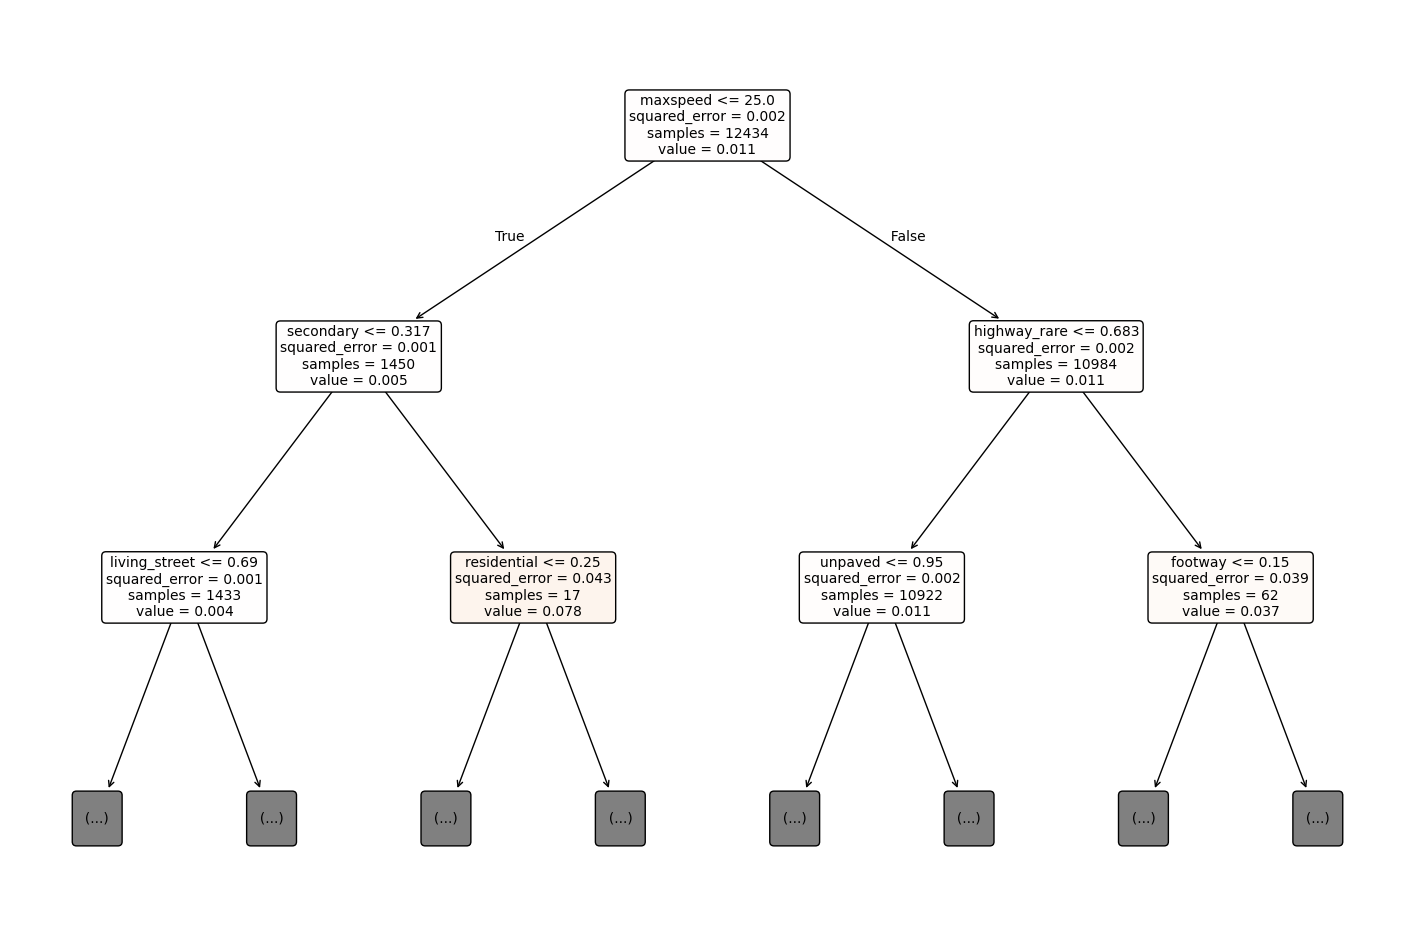

In [12]:
fig = plt.figure(figsize=(18,12))
_ = tree.plot_tree(dt, feature_names=X.columns, filled=True, rounded=True, max_depth = 2)

## Vorhersage auf den Testdaten & Bewertung

In [13]:
y_pred = dt.predict(X_test)

####  Modellbewertung: MSE und R²-Score

In [14]:
# Metriken berechnen
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [15]:
# Ergebnisse
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2 Score: {r2}")

Mean Squared Error (MSE): 0.0019223071007243532
Mean Absolute Error (MAE): 0.015566142845694363
Root Mean Squared Error (RMSE): 0.04384412276148712
R^2 Score: -0.2855134029822681


### Feature Importance

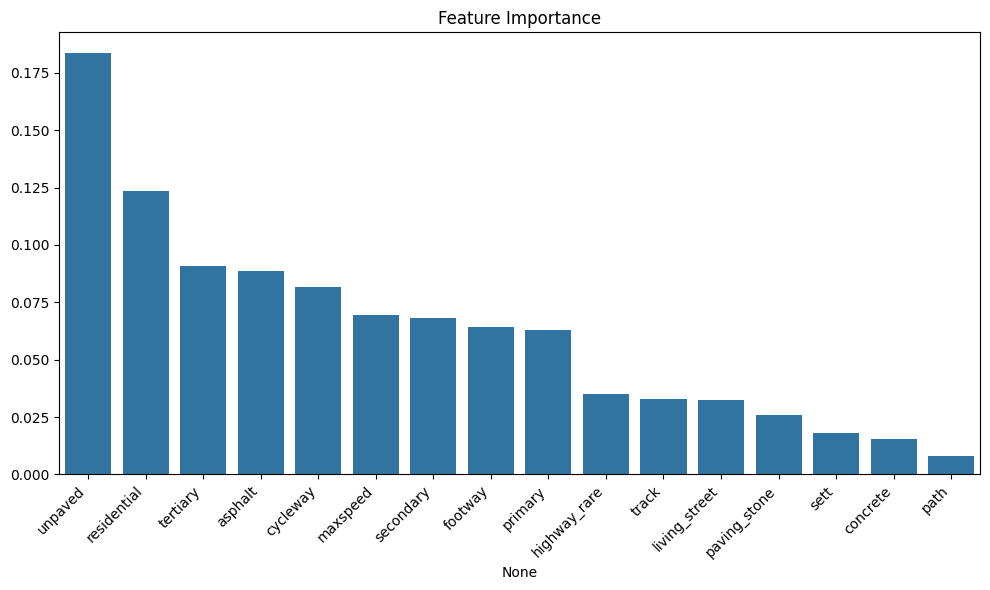

In [16]:
import numpy as np
import seaborn as sns

# Feature Importance extrahieren
importance = dt.feature_importances_

# Sortieren der Features nach Wichtigkeit
sorted_indices = np.argsort(importance)[::-1]

# Plot mit rotierter Achsenbeschriftung
plt.figure(figsize=(10, 6))
sns.barplot(x=X.columns[sorted_indices], y=importance[sorted_indices])
plt.xticks(rotation=45, ha='right')  # Beschriftung um 45 Grad rotieren
plt.title('Feature Importance')
plt.tight_layout()  # Automatische Anpassung des Layouts

## 3. Hyperparamtertuning mit GridSearch

Um die besten Hyperparameter zu finden, wird **Grid Search** in Kombination mit **Cross-Validation** genutzt.

#### Hyperparameter-Raum definieren

Im Fall eines Decision Tree-Regressors gibt es mehrere Hyperparameter, die optimiert werden können:

- `max_depth`: Maximale Tiefe des Baums.
- `min_samples_split`: Mindestanzahl von Samples, die notwendig sind, um einen Knoten zu teilen.
- `min_samples_leaf`: Mindestanzahl von Samples in einem Blatt.
- `max_features`: Maximale Anzahl von Features, die verwendet werden dürfen.

In [17]:
from sklearn.model_selection import GridSearchCV

# Definiere den Hyperparameter-Raum (inklusive max_features)
param_grid = {
    'max_depth': range(1, 21),  # Baumtiefen
    'min_samples_split': [2, 5, 10, 20],  # minimale Anzahl an Samples für Splits
    'min_samples_leaf': [1, 2, 4, 10],  # minimale Anzahl an Samples in einem Blatt
    'max_features': [None, 'sqrt', 'log2', 0.5]  # Werte für max_features
}

In [18]:
# Grid Search einrichten
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, scoring='r2')

In [19]:
# Grid Search ausführen
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=1), n_jobs=-1,
             param_grid={'max_depth': range(1, 21),
                         'max_features': [None, 'sqrt', 'log2', 0.5],
                         'min_samples_leaf': [1, 2, 4, 10],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='r2')

In [24]:
# Beste Parameter ansehen und Modell bewerten
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [25]:
# Modellvorhersagen treffen
y_pred = best_model.predict(X_test)

In [26]:
# Metriken berechnen
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [27]:
# Ergebnisse ausgeben
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2 Score: {r2}")

Mean Squared Error (MSE): 0.001494748462998325
Mean Absolute Error (MAE): 0.015016572754133112
Root Mean Squared Error (RMSE): 0.03866197696701922
R^2 Score: 0.000409881154038616


##  4. Cross-Validation (mit 5 Folds)

-  Anwendung der K-Fold Cross-Validation, um die Leistung deines Modells zu bewerten
  
Durch die Anwendung von Cross-Validation erhälten wir eine robustere Schätzung der Modellleistung als durch eine einfache Aufteilung der Daten in Trainings- und Testdaten. Dies hilft dabei sicherzustellen, dass unser Modell gut verallgemeinert.

In [28]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import make_scorer

In [29]:
# CV des besten Modells
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='r2')

In [30]:
from sklearn.model_selection import cross_validate

# Scoring-Metriken definieren
scoring = {
    'R2': 'r2',
    'MAE': make_scorer(mean_absolute_error),
    'MSE': make_scorer(mean_squared_error),
    'RMSE': make_scorer(root_mean_squared_error)
}

# Cross-Validation des besten Modells auf dem gesamten Trainingsdatensatz
cv_results = cross_validate(best_model, X_train, y_train, cv=5, scoring=scoring, return_train_score=True)

# Durchschnittliche Ergebnisse
print("Durchschnittliche Ergebnisse über die 5 Folds:")
print(f"R^2 Score: {cv_results['test_R2'].mean()}")
print(f"Mean Absolute Error (MAE): {cv_results['test_MAE'].mean()}")
print(f"Mean Squared Error (MSE): {cv_results['test_MSE'].mean()}")
print(f"Root Mean Squared Error (RMSE): {cv_results['test_RMSE'].mean()}")


Durchschnittliche Ergebnisse über die 5 Folds:
R^2 Score: 0.0010671241608335657
Mean Absolute Error (MAE): 0.01577171520316169
Mean Squared Error (MSE): 0.0019569451047214527
Root Mean Squared Error (RMSE): 0.044103250833149275


### Ansatz zum Umgang mit der Zielvariable: Skalierung oder Transformation der Zielvariable

#### Log-Transformation


In [31]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Log-Transformation der Zielvariable
y_train_log = np.log1p(y_train) # np.log1p(y) ist log(1 + y), um negative Werte zu vermeiden
y_test_log = np.log1p(y_test)

In [32]:
# Training des best_models mit der log-transformierten Zielvariable
best_model.fit(X_train, y_train_log)

DecisionTreeRegressor(max_depth=1, max_features='sqrt', random_state=1)

In [33]:
# Vorhersagen und Rücktransformation
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)  # Rücktransformation der Vorhersagen

In [34]:
# Metriken berechnen
y_test_original = np.expm1(y_test_log)  # Rücktransformation der Zielvariable

print(f"R^2 Score: {r2_score(y_test_original, y_pred)}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test_original, y_pred)}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test_original, y_pred)}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test_original, y_pred))}")

R^2 Score: 0.000720717752763611
Mean Absolute Error (MAE): 0.014556196175265277
Mean Squared Error (MSE): 0.0014942836499520294
Root Mean Squared Error (RMSE): 0.03865596525702119


### R²-Wert

Der R²-Wert (Bestimmtheitsmaß) gibt an, wie gut das Modell die Varianz der Zielvariable erklärt. Er liegt im Bereich von 0 bis 1, wobei:
- 1 bedeutet, dass das Modell die gesamte Varianz der Zielvariable perfekt erklärt.
- 0 bedeutet, dass das Modell die Varianz der Zielvariable überhaupt nicht erklärt.

Mit einem R²-Wert von `0.00040` bedeutet das:
- Dein Modell die Varianz der Zielvariable nicht erklärt.
- Dies deutet darauf hin, dass die aktuelle Modellkonfiguration wahrscheinlich schlecht an die Daten angepasst ist oder dass die Beziehung zwischen den Features und der Zielvariable möglicherweise nicht linear ist und nicht durch einen einfachen Entscheidungsbaum modelliert werden kann.
- Hinzu kommt die starke unsausgewogene Verteilung der Zielvariable. 

### MSE (Mean Squared Error)

Der Mittlere Quadratische Fehler (MSE) gibt den durchschnittlichen der quadrierten Fehler zwischen den vorhergesagten und den tatsächlichen Werten an. Ein niedrigerer MSE-Wert bedeutet eine bessere Anpassung des Modells. 

Mit einem MSE von `0.0019`:
- Dies ist dein Maß für den durchschnittlichen quadratischen Fehler. 
- ADer MSE im Kontext des Datensatzes und der Skalierung der Zielvariable betrachtet werden. Die Zielvariable liegt zwischen 0 und 1,5, wobei der Groteil der Werte bei Null liegt. 

## Vergleich Decision Tree - mit und ohne `service-Straßen

#### Modell **ohne** `service`: 

- Mean Squared Error (MSE): 0.001494748462998325
- Mean Absolute Error (MAE): 0.015016572754133112
- Root Mean Squared Error (RMSE): 0.03866197696701922
- R^2 Score: 0.000409881154038616
  

#### Modell **mit** `service`:

- Mean Squared Error (MSE): 0.0025629199994621115
- Mean Absolute Error (MAE): 0.01583723983392277
- Root Mean Squared Error (RMSE): 0.050625290117313024
- R^2 Score: 0.0013958778496783175


#### Fazit:

- Mit `service`-Straßen ist der R2-Score minimal höher, jedoch immer noch sehr niedrig, was darauf hindeutet, dass das Modell nur einen sehr kleinen Teil der Varianz in den Daten erklärt.
- Auf den ersten Blick scheint das Modell ohne die `service`-Straße präzisere Vorhersagen zu liefern, wie durch die niedrigeren Fehlermetriken (MSE, MAE, RMSE) angezeigt wird. Das muss jedoch im Zusammenhang mit der stark unausgewogenen Zielvariable gesehen werden, die zwischen 0 und 1 liegt, sowie den Großteil der Werte bei Null verzeichnet.
- Einfluss der unausgewogenen Daten:
    - Die stark unausgewogene Verteilung der Zielvariable könnte dazu führen, dass die Fehlermetriken verzerrt werden und daher ein Modell, das präzisere Vorhersagen für häufigere Null-Werte macht, bessere Fehlermetriken aufweist.

